Google search is great. You can ask any question you have and give you links to the potential solutions. It can sometimes give you the solution itself when the question is simple enough. One of such example is that google search can act as a calcualator. You can ask "1 + 1" or "1     + 1" to get the value 2. It somehow knows that the spaces are nuicense and return correct value. You can even ask the calculation with some strings. See pic below:

Using TensorFlow backend.


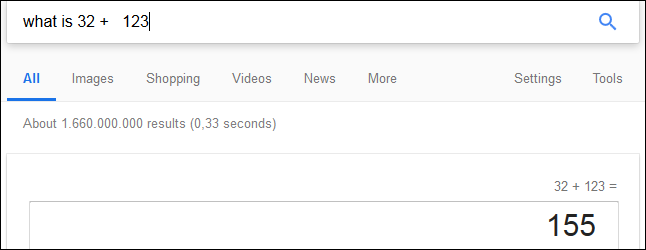

In [3]:
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img
load_img("./pic/Capture2.PNG")

Somehow, google understand that what I am asking is "32+123" and do the calculations. Can we do the same using deep learning model that takes a string as input?

I was fascinated by one of the Keras's examples in Github called [addition rnn](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py). This script shows the implementation of sequence to sequence learning for performing addition. The script considers the summation of two 3-digit numbers, for example, 123+420=543. The input of the model is a string "123+429" and output is "543". 

In this blog post, we try to understand how the RNNs learn calculations.
We will first consider very VERY simple example of summation of two 1-digits, then we will work on more complex senario. 



In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 2 GPU1
#### 0 GPU3
#### 4 GPU4
#### 3 GPU2
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.0.6
tensorflow version 1.2.1




## Create one-hot encoders that takes string and return one-hot encoded matrix of size as many as the number of characters in the string

This class is bollowed from [addition rnn](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py) with no change.

In [3]:
class CharacterTable(object): 
    """Given a set of characters: 
     + Encode them to a one hot integer representation 
     + Decode the one hot integer representation to their character output 
     + Decode a vector of probabilities to their character output 
    """ 
    def __init__(self, chars): 
        """Initialize character table. 
  
         # Arguments 
             chars: Characters that can appear in the input. 
        """ 
        self.chars = sorted(set(chars)) 
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) 
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) 
 
 
    def encode(self, C, num_rows): 
        """One hot encode given string C. 
  
         # Arguments 
             num_rows: Number of rows in the returned one hot encoding. This is 
                 used to keep the # of rows for each data the same. 
         """ 
        x = np.zeros((num_rows, len(self.chars))) 
        for i, c in enumerate(C): 
             x[i, self.char_indices[c]] = 1 
        return x 
 
 
    def decode(self, x, calc_argmax=True): 
        if calc_argmax: 
            x = x.argmax(axis=-1) 
        return ''.join(self.indices_char[x] for x in x) 
class colors: 
    ok = '\033[92m' 
    fail = '\033[91m' 
    close = '\033[0m' 


# RNN model for summation of two single digits.

## Generate 10,000 samples.
As we are only considering the summation of two single digits, there are only 10 x 10 = 100 possible samples.
Sampling 10,000 samples means we are sampling identical samples 100 times on average.

In [4]:
import numpy as np

set_seed(123)
# Parameters for the model and dataset. 
TRAINING_SIZE = 10000
DIGITS = 1


# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 
# int is DIGITS. 
MAXLEN = DIGITS + 1 + DIGITS 

# All the numbers, plus sign and space for padding. 
chars = '0123456789+ ' 
ctable = CharacterTable(chars) 
f = lambda: int(''.join(np.random.choice(list('0123456789')) 
            for i in range(np.random.randint(1, DIGITS + 1)))) 
questions = [] 
expected = [] 
print('Generating data...') 
while len(questions) < TRAINING_SIZE: 
    if len(questions) % 1000 == 0:
           print("{} samples are generated...".format(len(questions)))
    a, b = f(), f()  
    q = '{}+{}'.format(a, b) 
    query = q + ' ' * (MAXLEN - len(q)) 
    ans = str(a + b) 
    # Answers can be of maximum size DIGITS + 1. 
    ans += ' ' * (DIGITS + 1 - len(ans))  
    questions.append(query) 
    expected.append(ans) 
print('Total addition questions:{}'.format( len(questions)))


Generating data...
0 samples are generated...
1000 samples are generated...
2000 samples are generated...
3000 samples are generated...
4000 samples are generated...
5000 samples are generated...
6000 samples are generated...
7000 samples are generated...
8000 samples are generated...
9000 samples are generated...
Total addition questions:10000


## Example data strings look like:

In [5]:
for q,a in zip(questions,expected)[:10]:
    print("{:3} = {:4}".format(q,a))

2+2 = 4   
6+1 = 7   
3+9 = 12  
6+1 = 7   
0+1 = 1   
9+0 = 9   
0+9 = 9   
3+4 = 7   
0+0 = 0   
4+1 = 5   


# Using the class previously created, we one-hot encode each character.

## Input
There are 3 characters per sequence and each character could potential take 12 values ("0123456789+ ").
The input of the model is 3 one-hot encoded vectors each of which represents a single character. 
Hence one sample sequence is represented as 3 by 12. The example of the one-hot encoded vectors ($\boldsymbol{x}_{i,t} \in R^{12}$ The time index take values: $t=1,2,3$.) are:

- $\boldsymbol{x}_{i,t_1}=[0,0,0,0,0,0,1,0,0,0,0,0]$ indicates "6" as the 6th position (position counting starting from 0) is nonzero.  

- $\boldsymbol{x}_{i,t_2}=[0,0,0,0,0,0,0,0,0,0,1,0]$ indicates "+".

- $\boldsymbol{x}_{i,t_3}=[1,0,0,0,0,0,0,0,0,0,0,0]$ indicates "0".

- $[\boldsymbol{x}_{i,t_1},\boldsymbol{x}_{i,t_2},\boldsymbol{x}_{i,t_3}]$ together represents a single sentence "6+0"

- $\boldsymbol{x}_{i,t_4}=[0,0,0,0,0,0,0,0,0,0,0,1]$ indicates empty space i.e., " " 




## Targets
The targets are 2 one-hot encoded vectors, and each one-hot encoded vector must have length 12. 
If the solution is a single digit (for example, the solution to "0+6" is "6" and "6" is a single digit), then solution has to be "6 ", which can be represetned as  $[\boldsymbol{x}_{i,t_1}, \boldsymbol{x}_{i,t_4}]$ using the notation above. In practice we use $y$ to represent the target vectors.

$
\boldsymbol{y}_{i,k} \in [0,1]^{12}, k=1,2 
$

In [6]:
def one_hot_encoder(expected,questions,x_dim,y_dim,chars,ctable):
    print('Vectorization...') 
    x = np.zeros((len(questions), x_dim, len(chars)), dtype=np.bool) 
    y = np.zeros((len(questions), y_dim, len(chars)), dtype=np.bool) 
    for i, sentence in enumerate(questions): 
         x[i] = ctable.encode(sentence, x_dim) 
    for i, sentence in enumerate(expected): 
         y[i] = ctable.encode(sentence, y_dim)
    return(x,y)
x, y = one_hot_encoder(expected,questions,MAXLEN,DIGITS + 1,chars,ctable)

Vectorization...


## Split between training and testing


In [7]:
def split_train_test(x,y):
    # Explicitly set apart 10% for validation data that we never train over. 
    split_at = len(x) - len(x) // 10 
    (x_train, x_val) = x[:split_at], x[split_at:] 
    (y_train, y_val) = y[:split_at], y[split_at:] 
    return (x_train, x_val),(y_train, y_val)
(x_train, x_val),(y_train, y_val) = split_train_test(x,y)
print('Training Data:') 
print(x_train.shape) 
print(y_train.shape) 

Training Data:
(9000, 3, 12)
(9000, 2, 12)



# Model Definition

We consider encoder-decoder RNN models. 
The RNN is previously discussed [here](https://fairyonice.github.io/Understand%20Keras's%20RNN%20behind%20the%20scenes%20with%20a%20sin%20wave%20example.html).
The encoder-decoder model is often used in the field of machine translation, and it has been explained by many blogs. 
So I will not give you a nice smooth introduction, but interested readers should read (or at least see the graph) [Peeking into the neural network architecture used for Google's Neural Machine Translation](https://smerity.com/articles/2016/google_nmt_arch.html) or [How Does Attention Work in Encoder-Decoder Recurrent Neural Networks](https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/).

As the model's name suggests, from a high-level, the model is comprised of two sub-models: an encoder and a decoder.
- Encoder: The encoder is responsible for stepping through the input time steps and encoding the entire sequence into a fixed length vector called a context vector.
- Decoder: The decoder is responsible for stepping through the output time steps while reading from the context vector.

The original [addition rnn](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py) considers the solutions to the summation of two 3-or-less-digit numbers.
The model used was an encoder-decoder RNN with 208,529 parameters.
As there are 1 million potential combination sample (1,000 x 1,000), this number of parameters may be necessary considering the complexity of the problem. 


However, in my example, I only consider the summatoin of two single digit numbers, meaning that there are only 10 x 10 = 100 unique samples. 
The function with 100 if-else statements can do the perfect jobs in predicting the outcome.
So I should be able to create a model with less than 100 parameters! 
Simpler model is preferable also because it is easier to understand.

So for now, we consider an encoder-decoder model with 77 parameters. The model defenition follows:


```
HIDDEN_ENCODER=1
HIDDEN_DECODER=3
```

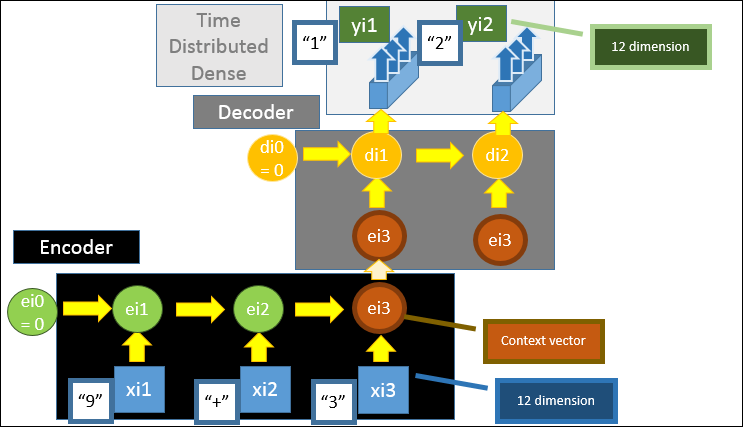

In [9]:
load_img("./pic/encoder_decoder.png")



## Encoder layer:

### In total there are 48 parameters ( = 12x1 + 1x1 + 1 = 12 + 1 + 1 = 14)

$
\boldsymbol{w}_{e} \in R^{\textrm{HIDDEN_ENCODER x 12}},\boldsymbol{w}_{h_{e}} \in R^{\textrm{HIDDEN_ENCODER x HIDDEN_ENCODER}}, \boldsymbol{b}_e \in R^{\textrm{HIDDEN_ENCODER}}
$

### layer definition

$
\boldsymbol{e}_{i,0}=0\in R^{\textrm{HIDDEN_ENCODER}}\\
\boldsymbol{e}_{i,t} = \textrm{tanh}(\boldsymbol{x}_{i,t}^T \boldsymbol{w}_{e} + \boldsymbol{e}_{i,t-1}^T \boldsymbol{w}_{e} +\boldsymbol{b}_e) \\ 
$

## Decoder layer:
### In total there are 21 parameters ( = 3x1 + 3x3 + 3 = 3 + 9 + 3 = 15)
$
\boldsymbol{w}_{d} \in R^{\textrm{HIDDEN_DECODER x HIDDEN_ENCODER}},\boldsymbol{w}_{h_{d}} \in R^{\textrm{HIDDEN_DECODER x HIDDEN_DECODER}}, \boldsymbol{b}_d \in R^{\textrm{HIDDEN_DECODER}}
$

### layer definition

$k=1,2$

$
\boldsymbol{d}_{i,0}=0\in R^{\textrm{HIDDEN_DECODER}}\\
\boldsymbol{d}_{i,k} = \textrm{tanh}(\boldsymbol{e}_{i,3}^T \boldsymbol{w}_{d} + \boldsymbol{d}_{i,k-1}^T
\boldsymbol{w}_{d} +\boldsymbol{b}_d) \\ 
$

## Time-distributed Dense layer:

### In total there are 48 parameters ( = 12x3 + 12 = 48)
$
\boldsymbol{w}_{dense}\in R^{\textrm{12 x HIDDEN_DECODER}}\boldsymbol{b}_{dense}\in R^{12}\\
$

### layer defenition
$
\boldsymbol{y}_{i,k} = \textrm{softmax}(\boldsymbol{d}_{i,k}^T \boldsymbol{w}_{dense} + \boldsymbol{b}_{dense})
$

In [8]:
import keras.layers as layers
from keras.models import Model
from keras.layers.core import Dense


print('Build model...')

 

def define_model(MAXLEN_x,MAXLEN_y,chars,
                 HIDDEN_ENCODER,
                 HIDDEN_DECODER,RNN):
    
    def scalarToList(a):
        if not isinstance(a,list):
            a = [a]
        lena = len(a)
        return(a,lena)
    def return_seq(nlayer,lenEncoder):
        '''
        return sequence must be False if this layer is the final one
        '''
        return(False if nlayer == lenENCODER else True)

    
    HIDDEN_ENCODER, lenENCODER = scalarToList(HIDDEN_ENCODER)
    HIDDEN_DECODER, lenDECODER = scalarToList(HIDDEN_DECODER)

    
    inp = layers.Input(batch_shape=(None, MAXLEN_x, len(chars)),name="Input")  
    
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE. 
    
    encoder = RNN(HIDDEN_ENCODER[0], 
                  return_sequences=return_seq(1,lenENCODER),
                  name="encoder1")(inp)
    
    nlayer = 1
    if lenENCODER > 1:
            for HE in HIDDEN_ENCODER[1:]:
                nlayer +=1
                encoder = RNN(HE, 
                          return_sequences=return_seq(nlayer,lenENCODER),
                          name="encoder"+str(nlayer))(encoder)
    
    rep_encoder = layers.RepeatVector(MAXLEN_y,name="repeat_vector")(encoder)
    # By setting return_sequences to True, return not only the last output but 
    # all the outputs so far in the form of (num_samples, timesteps, 
    # output_dim). This is necessary as TimeDistributed in the below expects 
    # the first dimension to be the timesteps.
    decoder = RNN(HIDDEN_DECODER[0],
                  return_sequences=True,
                  name="decoder1")(rep_encoder)
    
    if lenDECODER > 1:
            for HE in HIDDEN_DECODER[1:]:
                decoder = RNN(HE, 
                          return_sequences=True,
                          name=name+str(nlayer))(decoder)
    
    # Apply a dense layer to the every temporal slice of an input. For each of step 
    # of the output sequence, decide which character should be chosen. 
    #out = layers.Dense(len(chars))(decoder)
    out = layers.TimeDistributed(layers.Dense(len(chars),
                                              activation="softmax"),
                                 name="time_distributed_dense")(decoder)
    
    model = Model(inputs=[inp],outputs=[out])
    encoder = Model(inputs=[inp],outputs=[rep_encoder])
    model.summary() 
    return(model,encoder)

HIDDEN_ENCODER = 1#128
HIDDEN_DECODER = 3#128
model, encoder = define_model(MAXLEN,DIGITS + 1,chars,
                              HIDDEN_ENCODER,
                              HIDDEN_DECODER,
                              RNN=layers.SimpleRNN)    

model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']) 



Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 12)             0         
_________________________________________________________________
encoder1 (SimpleRNN)         (None, 1)                 14        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 1)              0         
_________________________________________________________________
decoder1 (SimpleRNN)         (None, 2, 3)              15        
_________________________________________________________________
time_distributed_dense (Time (None, 2, 12)             48        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


Define printing functions for model training 

In [9]:
def print_predicted(x,y,model,ctable,colors):
    for i in range(x.shape[0]): 
        rowx, rowy = x[[i]], y[[i]]
        preds = model.predict(rowx, verbose=0) 
        preds = preds.argmax(axis=2)
        q = ctable.decode(rowx[0]) 
        correct = ctable.decode(rowy[0]) 
        guess = ctable.decode(preds[0], calc_argmax=False) 
        print('  Q:{}'.format(q)), 
        print('T:{}'.format( correct)), 
        print('Model:{}'.format(guess)),
        if correct == guess: 
             print(colors.ok + '☑' + colors.close) 
        else: 
             print(colors.fail + '☒' + colors.close) 

## Model Training 

In [10]:
def train(model,ctable,
          x_train,y_train,x_val,y_val,
          nb_epochs,print_every,BATCH_SIZE):
    history = {'acc':[],'loss':[],'val_acc':[],'val_loss':[]}
    for iteration in range(1, nb_epochs): 
        hist = model.fit(x_train, y_train, 
                         batch_size=BATCH_SIZE, 
                         epochs=1,
                         verbose=False, 
                         validation_data=(x_val, y_val))
        ## printing 
        if iteration % print_every ==0:
            print('-' * 50)
            print('Iteration {}'.format(iteration))

        for key in hist.history.keys():
            history[key].append(hist.history[key][0])
            if iteration % print_every ==0:
                print("{}:{:4.3f}".format(key,hist.history[key][0])),

        if iteration % print_every ==0:    
            print("")

        # Select 10 samples from the validation set at random so we can visualize 
        # errors. 
        if iteration % print_every ==0: 
            index = np.random.randint(0, len(x_val),10)
            print_predicted(x_val[index],y_val[index],
                            model,ctable,colors)
    return(history)

In [11]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

set_seed()
history = train(model,ctable,
          x_train,y_train,x_val,y_val,
          nb_epochs=2001,print_every=400,BATCH_SIZE=128)

((9000, 3, 12), (9000, 2, 12), (1000, 3, 12), (1000, 2, 12))
--------------------------------------------------
Iteration 400
acc:0.909 loss:0.435 val_acc:0.908 val_loss:0.437 
  Q:6+0 T:6  Model:6  ☑
  Q:6+1 T:7  Model:7  ☑
  Q:3+9 T:12 Model:12 ☑
  Q:2+8 T:10 Model:10 ☑
  Q:2+9 T:11 Model:11 ☑
  Q:5+9 T:14 Model:13 ☒
  Q:8+6 T:14 Model:13 ☒
  Q:6+9 T:15 Model:12 ☒
  Q:0+0 T:0  Model:5  ☒
  Q:0+6 T:6  Model:6  ☑
--------------------------------------------------
Iteration 800
acc:0.958 loss:0.233 val_acc:0.950 val_loss:0.234 
  Q:4+2 T:6  Model:6  ☑
  Q:9+2 T:11 Model:11 ☑
  Q:8+4 T:12 Model:12 ☑
  Q:3+9 T:12 Model:12 ☑
  Q:2+7 T:9  Model:9  ☑
  Q:0+3 T:3  Model:4  ☒
  Q:3+3 T:6  Model:6  ☑
  Q:6+0 T:6  Model:6  ☑
  Q:6+3 T:9  Model:9  ☑
  Q:6+9 T:15 Model:15 ☑
--------------------------------------------------
Iteration 1200
acc:0.985 loss:0.142 val_acc:0.985 val_loss:0.142 
  Q:3+2 T:5  Model:5  ☑
  Q:1+7 T:8  Model:8  ☑
  Q:7+4 T:11 Model:11 ☑
  Q:6+7 T:13 Model:13 ☑
  Q:3+1 T:4  M

## The validation loss and the training loss
This small model performs surprisingly well.
Since both training and testing data contain all possible samples, the model performance in the two data is the same.

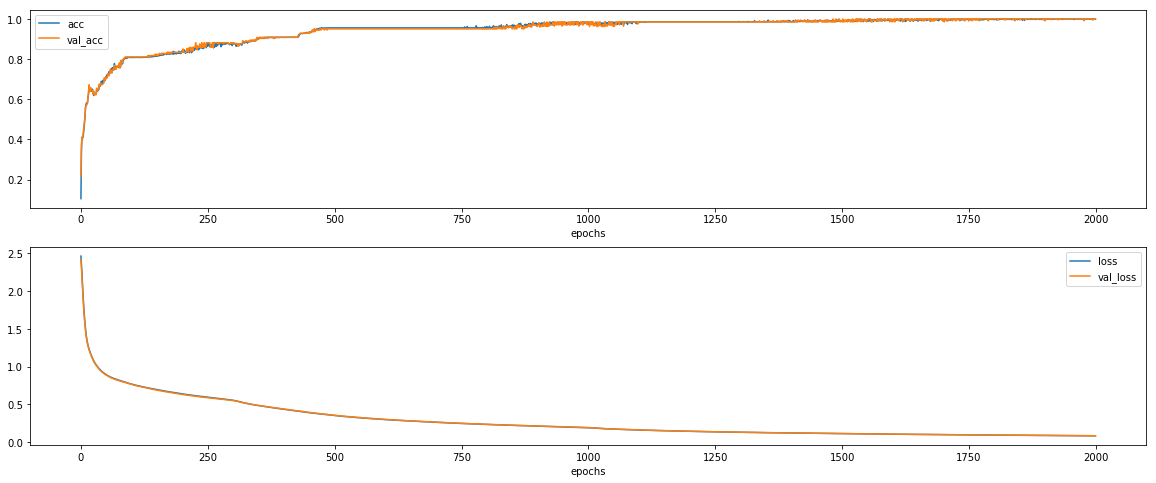

In [12]:
def plot_loss_acc(history):
    fig = plt.figure(figsize=(20,8))
    labels = [["acc","val_acc"],["loss","val_loss"]]

    count = 1
    for ilab in range(len(labels)):
        ax = fig.add_subplot(2,1,count)
        count += 1
        for label in labels[ilab]:
            ax.plot(history[label],label=label)
            ax.set_xlabel("epochs")    
        plt.legend()
    plt.show()
plot_loss_acc(history)


## Plot encoders

My encoder only has 1 dimention.

I plot the values of this encoder for every possible sample values.

The plot shows that 1 + 3, 2 + 2 and 3 + 1 receive the same encoder value.
Similarly, 1 + 5, 2 + 4, 3 + 3, 4 + 2 and 1 + 5  receive the same encoder value.

In fact, plot shows that the ecoder seems to record the (scaled) values of summation.
Encoders discard the infomation of what original digits were and remember only the summation values.



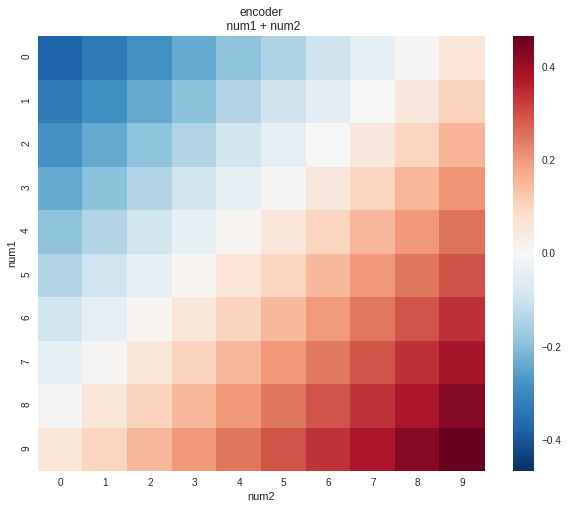

In [13]:
import seaborn as sns
import pandas as pd 

hidden = {"encoder": [],"num1":[],"num2":[]}
for num1 in range(10):
    for num2 in range(10):
        string = "{}+{}".format(num1,num2)
        myx = ctable.encode(string,MAXLEN)
        e = encoder.predict(myx.reshape(1,myx.shape[0],myx.shape[1]))[0]
        ## notice that the predicted encoders are duplicated twice k = 1 , 2 
        ## because of repeatVector
        ## we only extract one of the vector.
        if ~ np.all(e[0] == e[1]): ## should never be TRUE!
            print("ERROR!") 
        h = e[0]
        hidden["encoder"].append(h[0])    
        hidden["num1"].append(num1)
        hidden["num2"].append(num2)
hidden = pd.DataFrame(hidden)
sns.set()
plt.figure(figsize=(10,8))
sns.heatmap(hidden.pivot("num1","num2","encoder"))
plt.title("encoder\n num1 + num2")
plt.show()


# Deep learning calculators for more complex calculations
Now I consider creating a deep learning calculator for more complex calculations: 

- Mupltiple operations: summation (+), negation (-), multiplication (*) and devision (/).
- Number of digits up to 3 (i.e., 0 - 999) as an input
- Allow " " to appear in the input calculation e.g., "1 23 + 3  12" = "123+312". However, output is clean: it does not contain space in between digits.

This results in more characters in my character dictionary.
In addition to '0123456789+ ', now I have '-*/Na'. Na arises because when a number is devided by 0 the output sould be "NaN   ".

I consider integer devision. This means, for example,  1/3 = 0, 5/3=1.


I tried to train a model with the trainig data having the same size, i.e., 10,000. But it seemd that 10,000 samples is not enough to create a generalizable model. This makes sense because previously we only have 100 combinatiosn of problems (=10x10). But now, there are 4 million (4,000,000 = 4*1,000^2) combinations of problems (even excluding the spaces that can randomly appear in the left hand side of the equation). The problem is much more complex! I demonstrate the data training with 100,000 samples.  

In [20]:
## "N" and "a" are  
set_seed()
TRAINING_SIZE = 100000

chars2 = '0123456789+-*/Na ' 
print("The number of characters in dictionary: {}".format(len(chars2)))
ctable2 = CharacterTable(chars2) 
DIGITS = 3

MAXLEN_x = DIGITS + 1 + DIGITS
## Maximum length of the output would occur 
## when 99999x99999=9,999,800,001 which has length 10
MAXLEN_y = int(np.ceil(np.log10( ((10**DIGITS)-1)**2 )))

def frand(): 
    st = ''
    for i in range(DIGITS):
        st += str(np.random.choice(list('0123456789 ')))
    if st==' '*DIGITS:
          st = frand()          
    return st
## arithmetic operation
foperation = lambda: np.random.choice(list('+/*-')) 

def get_answer(a,b,oper):
    clean = lambda a: int(a.replace(" ","")) 
    a = clean(a)
    b = clean(b)
    if oper=="+":
        out = a + b
    elif oper=="-":
        out = a - b
    elif oper=="*":
        out = a*b
    elif oper=="/":
        if b == 0:
            out = "NaN"
        else:
            out = a/b
    return(out)

questions = [] 
expected = [] 
 
print('Generating data...') 
while len(questions) < TRAINING_SIZE: 
    if len(questions) % 10000 == 0:
           print("{} samples are generated...".format(len(questions)))

    a, b, oper = frand(), frand(), foperation() 
    
    # Pad the data with spaces such that it is always MAXLEN. 
    q = '{}{}{}'.format(a,oper, b) 
    query = q + ' ' * (MAXLEN_x - len(q)) 
    ans = str(get_answer(a,b,oper)) 
    # Answers can be of maximum size MAXLEN_y. 
    ans += ' ' * (MAXLEN_y - len(ans))  
    questions.append(query) 
    expected.append(ans) 
print('Total addition questions:{}'.format( len(questions)))

The number of characters in dictionary: 17
Generating data...
0 samples are generated...
10000 samples are generated...
20000 samples are generated...
30000 samples are generated...
40000 samples are generated...
50000 samples are generated...
60000 samples are generated...
70000 samples are generated...
80000 samples are generated...
90000 samples are generated...
Total addition questions:100000


## Example data strings look like:

In [15]:
for q, e in zip(questions,expected)[:20]:
    print("{} = {}".format(q,e))

226-13  = 213   
961+019 = 980   
093+400 = 493   
173*247 = 42731 
480+793 = 1273  
461/562 = 0     
83 *502 = 41666 
 62/446 = 0     
3 0-647 = -617  
671/ 57 = 11    
248/121 = 2     
359*081 = 29079 
335*979 = 327965
333-869 = -536  
639/666 = 0     
 34/310 = 0     
868-910 = -42   
134+761 = 895   
337/686 = 0     
447+009 = 456   


## One-hot encoding and split between training and testing.

In [16]:
x, y = one_hot_encoder(expected,questions,MAXLEN_x,MAXLEN_y,chars2,ctable2)
(x_train, x_val),(y_train, y_val) = split_train_test(x,y)

Vectorization...


## Define Model
This time, I consider LSTM with more nodes and more layers for encoders!

Note we also  consider the encoder structure with bottole neck encoder dimention to be 1.
This model was converging prohibitably slow: e.g., at epoch 500, it was still about validation accuracy was still as low as 0.6. Due to the computational resource, we consider complex model that converges faster.

In [17]:
set_seed()

model2, encoder2 = define_model(MAXLEN_x,MAXLEN_y,chars2,
                                HIDDEN_ENCODER=[256],
                                HIDDEN_DECODER=[256],
                              RNN=layers.LSTM)    

model2.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 7, 17)             0         
_________________________________________________________________
encoder1 (LSTM)              (None, 256)               280576    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 256)            0         
_________________________________________________________________
decoder1 (LSTM)              (None, 6, 256)            525312    
_________________________________________________________________
time_distributed_dense (Time (None, 6, 17)             4369      
Total params: 810,257
Trainable params: 810,257
Non-trainable params: 0
_________________________________________________________________


## Training

In [18]:
set_seed()
history2 = train(model2,ctable2,
                x_train,y_train,x_val,y_val,
                nb_epochs=100,#2000
                print_every=10,
                BATCH_SIZE=64)

--------------------------------------------------
Iteration 10
acc:0.799 loss:0.504 val_acc:0.801 val_loss:0.498 
  Q:405*934 T:378270 Model:359600 ☒
  Q:799+472 T:1271   Model:1271   ☑
  Q:33 *952 T:31416  Model:30966  ☒
  Q:283+926 T:1209   Model:1211   ☒
  Q:232+59  T:291    Model:399    ☒
  Q: 88/154 T:0      Model:0      ☑
  Q:412*280 T:115360 Model:110880 ☒
  Q:787+074 T:861    Model:861    ☑
  Q:2 3+ 39 T:62     Model:50     ☒
  Q:1 7/397 T:0      Model:0      ☑
--------------------------------------------------
Iteration 20
acc:0.904 loss:0.256 val_acc:0.886 val_loss:0.296 
  Q:077/558 T:0      Model:0      ☑
  Q:765* 60 T:45900  Model:46300  ☒
  Q:037+3 8 T:75     Model:75     ☑
  Q: 54-721 T:-667   Model:-667   ☑
  Q:308-666 T:-358   Model:-358   ☑
  Q:976/619 T:1      Model:1      ☑
  Q: 19/127 T:0      Model:0      ☑
  Q:982+899 T:1881   Model:1881   ☑
  Q:426/669 T:0      Model:0      ☑
  Q:8  -5 2 T:-44    Model:-44    ☑
--------------------------------------------------

## Plot validation and accuracy over epochs

The validation loss starts increasing after 30 epochs indicating that the model overfits.
On the other hand, the overfitting behavior cannot be seen from the validation accuracy (it remains the same (and not decreasing) after the 40 epochs.)
This is probably because the accuracy is a more "corse" measure than the "softmax-categorical_crossentropy" which was used as our loss.

I would increase training sample size or change the model structure to improve the model performance.

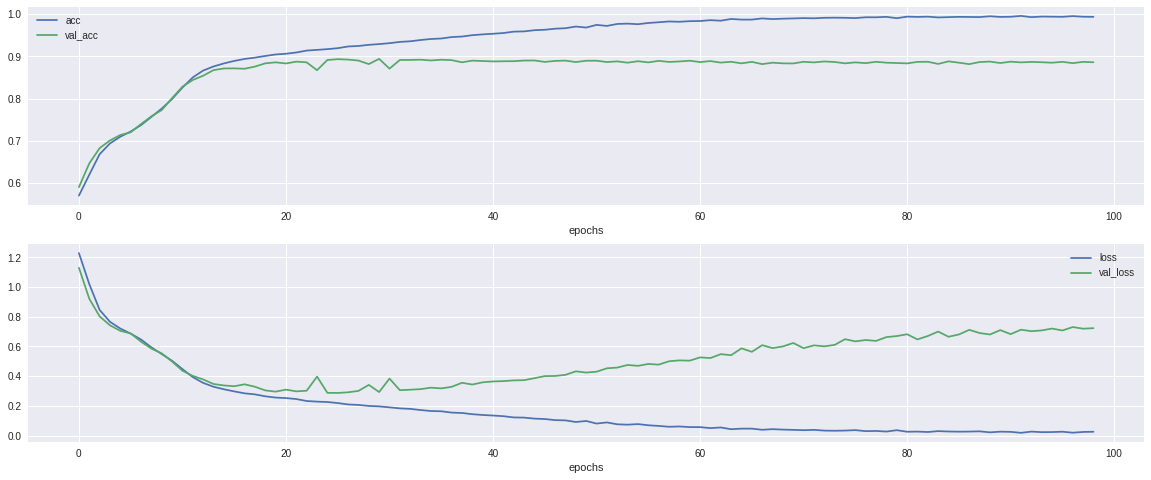

In [19]:
plot_loss_acc(history2)

# Model performance
The code block below shows the randomly selected 100 validation samples.
It is clear that the model performance is reasonable in many problems but the performance becomes poor when the solution requires more than 4 digits.

In [30]:
set_seed(1)
random_index = np.random.choice(x_val.shape[0],100,replace=False)
print_predicted(x_val[random_index],
                y_val[random_index],
                model2,ctable2,colors)

  Q:478+629 T:1107   Model:1107   ☑
  Q:383*249 T:95367  Model:944977 ☒
  Q:231-94  T:137    Model:137    ☑
  Q:841/232 T:3      Model:3      ☑
  Q:151+448 T:599    Model:597    ☒
  Q:539-661 T:-122   Model:-122   ☑
  Q:9 5*474 T:45030  Model:44070  ☒
  Q:801+180 T:981    Model:981    ☑
  Q:767/260 T:2      Model:2      ☑
  Q:079/983 T:0      Model:0      ☑
  Q:180+926 T:1106   Model:1106   ☑
  Q:411+515 T:926    Model:926    ☑
  Q: 78/983 T:0      Model:0      ☑
  Q:067+029 T:96     Model:96     ☑
  Q:595+ 76 T:671    Model:671    ☑
  Q:182/691 T:0      Model:0      ☑
  Q:  5+800 T:805    Model:805    ☑
  Q:238-617 T:-379   Model:-379   ☑
  Q: 05- 64 T:-59    Model:-59    ☑
  Q:734-59  T:675    Model:675    ☑
  Q:53 +037 T:90     Model:80     ☒
  Q:326-157 T:169    Model:169    ☑
  Q:681+695 T:1376   Model:1376   ☑
  Q:1 0/6 9 T:0      Model:0      ☑
  Q:825/518 T:1      Model:1      ☑
  Q:3 4/809 T:0      Model:0      ☑
  Q:097+312 T:409    Model:409    ☑
  Q:435*892 T:388020 Model:3